In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

In [13]:
data= pd.read_csv('./datasets/passenger.csv', parse_dates=['Month'],index_col='Month')
#split data into train and test
train= data[:int(0.8*(len(data)))]
test= data[int(0.8*(len(data))):]

# data_diff= data.diff().dropna()

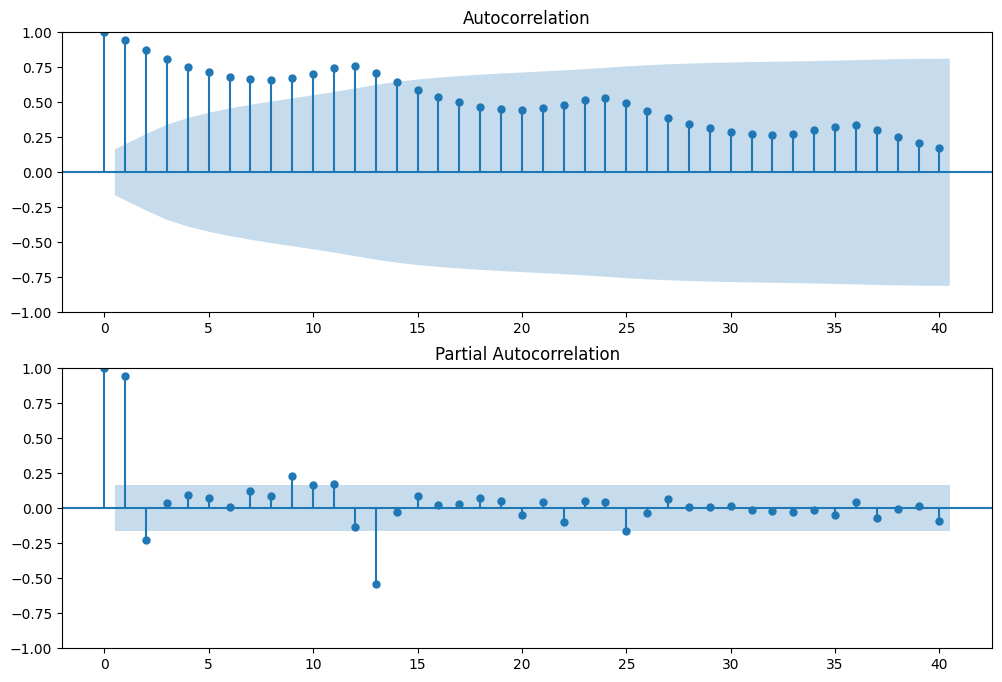

In [3]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data.values.squeeze(), lags=40, ax=ax1) # Q q ,spikes patterns for seasonal period too

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data, lags=40, ax=ax2) # P p


**Lags**

In [4]:
pacf_values, pconfint = sm.tsa.pacf(data, nlags=40, alpha=0.05, method='ywmle')
# Sort PACF values and get top n
top_n = 10
sorted_pacf_indices = np.argsort(np.abs(pacf_values))[-top_n:]  # Sort by absolute value of PACF
sorted_pacf_values = pacf_values[sorted_pacf_indices]

# Print top sorted values
print("Top sorted PACF values for lags:")
p_choices=[]
for plag, pacf in zip(sorted_pacf_indices, sorted_pacf_values):
    print(f"Lag {plag+1}: PACF {pacf:.4f}")
    p_choices.append((pacf,plag+1))

p_choices=sorted(p_choices,key=lambda x: abs(x[0]), reverse=True)

potential_lags=[]

for pcf, plag in p_choices:
    if abs(pcf)>=0.2:
        potential_lags.append(plag)

if len(potential_lags)<3:
    potential_lags=[x[1] for x in p_choices[:3]]

print(potential_lags)

Top sorted PACF values for lags:
Lag 8: PACF 0.1256
Lag 13: PACF -0.1354
Lag 26: PACF -0.1627
Lag 11: PACF 0.1661
Lag 12: PACF 0.1713
Lag 3: PACF -0.2294
Lag 10: PACF 0.2325
Lag 14: PACF -0.5397
Lag 2: PACF 0.9480
Lag 1: PACF 1.0000
[1, 2, 14, 10, 3]


In [5]:
largest_lag=max(potential_lags)
largest_dataset=data.copy()

for lag in range(1,largest_lag+1):
    largest_dataset[f"lag{lag}"]=data.shift(lag)

**XGBOOST**

In [28]:
curr_dataset = largest_dataset.iloc[:, :15].dropna()  # Slide rows, cols in matrix (iloc transforms df to matrix)

y_train = curr_dataset['Passengers'][:int(0.8*(len(data)))]
X_train = curr_dataset[:int(0.8*(len(data)))].drop(columns='Passengers')
y_test, x_test = curr_dataset['Passengers'][int(0.8*(len(data))):], curr_dataset[int(0.8*(len(data))):].drop(columns='Passengers')

model= XGBRegressor(n_estimators=50,n_jobs=-1)
model.fit(X_train, y_train)
pred=model.predict(x_test)
print(mean_absolute_error(y_test, pred))

31.827960205078124


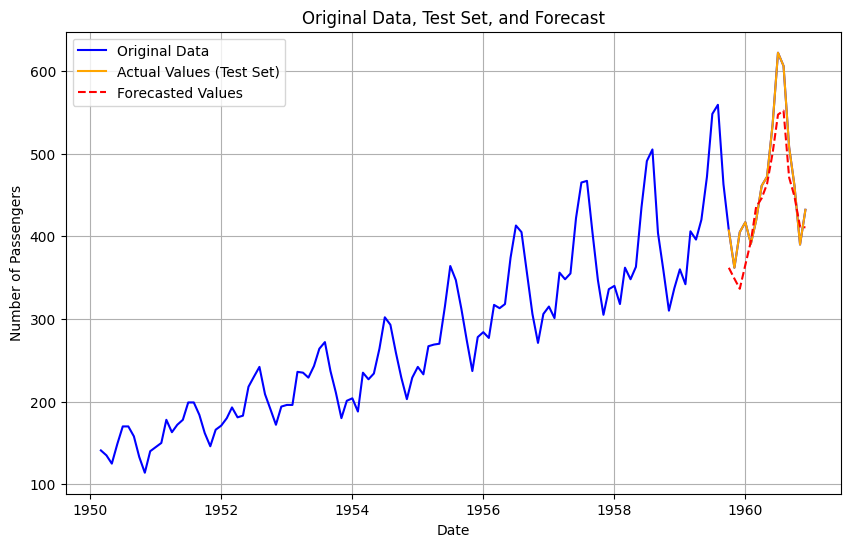

In [25]:
data= pd.read_csv('./datasets/passenger.csv')
combined_index = pd.concat([pd.Series(train.index), pd.Series(test.index)])
forecast_values = pred

# Plot the original data
plt.figure(figsize=(10, 6))
plt.plot(curr_dataset.index, curr_dataset["Passengers"], label="Original Data", color="blue")

# Plot the actual test data
plt.plot(y_test.index, y_test.values, label="Actual Values (Test Set)", color="orange")

# Plot the forecasted values
plt.plot(y_test.index, forecast_values, label="Forecasted Values", color="red", linestyle="dashed")

# Add title, legend, and labels
plt.title("Original Data, Test Set, and Forecast")
plt.xlabel("Date")
plt.ylabel("Number of Passengers")
plt.legend()
plt.grid()
plt.show()

**Cross Validation for determining lag**

In [29]:

min_mae= 1000000000
best_lag=-1

scaler = StandardScaler()

for lag in potential_lags:
    curr_dataset = largest_dataset.iloc[:, :lag + 1].dropna()  # Slide rows, cols in matrix (iloc transforms df to matrix)

    y = curr_dataset['Passengers']
    X = curr_dataset.drop(columns='Passengers')

    tscv = TimeSeriesSplit(n_splits=5)

    model = XGBRegressor(n_jobs=-1)

    average = []
    # Cross-validation
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Apply StandardScaler
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # model.fit(X_train_scaled, y_train)
        model.fit(X_train_scaled, y_train, eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)], verbose=False) 
        predictions = model.predict(X_test_scaled)
        mae = mean_absolute_error(y_test, predictions)
        average.append(mae)
        
    print(lag, np.mean(average))
    if np.mean(average) < min_mae:
        min_mae = np.mean(average)
        best_lag = lag

print(f"Best MAE: {min_mae}")
print(f"Best lag: {best_lag}")


1 46.26220358143682
2 44.99547676418138
14 30.247411382766
10 49.63249525590377
3 57.79674629543139
Best MAE: 30.247411382766
Best lag: 14
